# Computing vibronic Hamiltonian in the many-body (TD-DFTB or TD-DFT) basis

<a name="toc"></a>
## Table of contents

1. [General setups](#1)

  1.1. [Import all the needed Libra modules](#1.1)
  
  1.2. [Unpack the data archive](#1.2)

2. [Get the single-particle information](#2)

3. [Read the TD-DFTB output files and get all the needed information](#3)

  3.1. [Get the information from the TD-DFTB calculations](#3.1)
  
  3.2. [Reindex the single-particle excitations into a format expected by Libra](#3.2)
  
  3.3. [Order/sort the single-particle excitations at each timestep by energy or identity](#3.3)

4. [Compute overlaps and time-overlaps between the SD states](#4)

5. [Compute vibronic Hamiltonian in the many-body basis](#5)

  5.1. [Read the the list of excitation energies at each timestep, and compute the midpoints](#5.1)
  
  5.2. [Make the transformation matrix from the single-particle to many-body basis at each time step](#5.2)
  
  5.3. [Compute overlaps and time-overlaps in the CI basis](#5.3)
  
  5.4. [Apply orthonormalization to the many-body basis, apply state reordering, and phase correction](#5.4)
  
  5.5. [Compute the Hvib in the many-body basis and print out Hvib, S, and St in the many-body basis](#5.5)
 
6. [Plotting the MB couplings and energies](#6)

7. [User-friendly version of the above workflow](#7)

8. [Workflow for the CP2K data](#8)


### A. Learning objectives
* To compute vibronic Hamiltonians for TD-DFT(B) states based on data from DFTB+ or CP2K calculations
* To to visualize the vibronic Hamiltonian properties
* To get an overview of the auxiliary functions that are used in the user-friendly workflow


### B. Use cases
* [TD-DFT(B) NAC plotting](#nac_plotting-1)
* [TD-DFT(B) energy vs time plotting](#energy_plotting-1)
* [Compute vibronic Hamiltonian in MB basis](#mb_hvib-1)
* [DFTB+/Libra interface](#dftb-1)
* [CP2K/Libra interface](#cp2k-1)


### C. Functions

- `libra_py`
  - `workflows`
    -  `nbra`
      - `mapping`
        - [`ovlp_mat_arb`](#ovlp_mat_arb-1)
      - `step2_many_body`
        - [`reindex_cp2k_sd_states`](#reindex_cp2k_sd_states-1)
      - `step3`                
        - [`apply_normalization`](#apply_normalization-1)
        - [`apply_phase_correction`](#apply_phase_correction-1)
        - [`apply_orthonormalization_general`](#apply_orthonormalization_general-1)
        - [`apply_state_reordering_general`](#apply_state_reordering_general-1)
        - [`apply_phase_correction_general`](#apply_phase_correction_general-1)    
        - [`sort_unique_SD_basis`](#sort_unique_SD_basis-1)
        - [`get_step2_data`](#get_step2_data-1)
      - `step3_many_body`
        - [`get_step2_mb_sp_properties`](#get_step2_mb_sp_properties-1)
        - [`compute_ci_energies_midpoint`](#compute_ci_energies_midpoint-1)
        - [`make_T_matrices`](#make_T_matrices-1)
        - [`run`](#run-1)        
  - `data_stat`
    - [`cmat_stat2`](#cmat_stat2-1)

## 1. General setups 
[Return to TOC](#toc)<a name="1"></a>

### 1.1. Import all the needed Libra modules 
[Return to TOC](#toc)<a name="1.1"></a>

and other dependencies such as numpy and matplotlib

In [1]:
import os, sys, time, math, cmath
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units as units
from libra_py import influence_spectrum as infsp
from libra_py import data_visualize, data_conv, data_read, data_stat, data_outs
from libra_py.workflows.nbra import mapping, step2_many_body, step3, step4, step3_many_body

/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::v

### 1.2. Unpack the data archive
[Return to TOC](#toc)<a name="1.2"></a>

This tutorial comes with two tarballs - obtainded from DFTB+ and CP2K calculations with TD-DFTB and TD-DFT respectively. We will first focus on the DFTB+ example, but the CP2K calculations are very similar and we'll briefly touch upon them later.

We first unpack data (uncomment the instruction below to run it from Jupyter - don't remove the exclamation mark)

In [2]:
#!tar -xf dftb_data.tar.bz2

This will produce a folder `dftb_data` with the following structure:

 * `res` - contains the single-particle (orbital-basis) energies, overlaps and time-overlaps
 * `all_logfiles` - contains the files produced by the TD-DFTB calculations in step2
 * `wd` - is a working directory, showing 5 folders - one per each jobs submitted in step2. The big/binary files that may be produced in actual step2 calculations are not shown. This directory is here just to illustrate where to look for which files. The directory `all_logfiles` just contains a subset of the files from `wd`, but combined together. This can be done manually of with a simple bash script.
 * `res_mb_sp_ref` and `res_mb_sp2_ref` - the reference folders with the content of the `res_mb_sp` and `res_mb_sp2` generated in this tutorial

## 2. Get the single-particle information
[Return to TOC](#toc)<a name="2"></a>

Read the files that have the energies, overlaps, and time-overlap matricies in the Kohn-Sham basis: E_ks, S_ks, and St_ks. This is done with the `step3.get_step2_data` function: 
<a name="get_step2_data-1"></a>

In [3]:
help(step3.get_step2_data)

Help on function get_step2_data in module libra_py.workflows.nbra.step3:

get_step2_data(_params)
    A light function to obtain the step2 data: S, St, hvib
    
    Args:
        params ( dictionary ): Control paramerter of this type of simulation. Can include the follwing keys:
    
        * **params["read_S_data"]** ( int ): whether to read S data (1) or not (0) [ default: 1 ]
    
        * **params["S_data_re_prefix"]** ( string ): prefix of files containing real part of orbital overlaps [ default: "S_dia_ks_" ]
    
        * **params["S_data_re_suffix"]** ( string ): suffix of files containing real part of orbital overlaps [ default: "_re" ]
    
        * **params["S_data_im_prefix"]** ( string ): prefix of files containing imaginary part of orbital overlaps [ default: "S_dia_ks_" ]
    
        * **params["S_data_im_suffix"]** ( string ): suffix of files containing imaginary part of orbital overlaps [ default: "_im" ]
    
        * **params["read_St_data"]** ( int ): whether

In [4]:
params = {}
path = os.getcwd()
params["data_set_paths"] = [ F"{path}/dftb_data/res/" ]  # where the step2 data is located
params["data_dim"] = 62 # the number of rows/columsn in E_ks files
params["active_space"] = range(0,int(62/2)) # alpha channel only here 
params["isnap"] = 150 # numbering of the first available file
params["fsnap"] = 199 # number of the final step

# The rest is just the suffixes/prefixes
params.update( { "read_S_data" : 1, "read_S_re":1,  "read_S_im":0,
                 "S_data_re_prefix": "S_ks_",  "S_data_re_suffix": "_re",
                 "S_data_im_prefix": "S_ks_",  "S_data_im_suffix": "_im",
                 "read_St_data" : 1, "read_St_re":1,  "read_St_im":0,
                 "St_data_re_prefix": "St_ks_",  "St_data_re_suffix": "_re",
                 "St_data_im_prefix": "St_ks_",  "St_data_im_suffix": "_im",
                 "read_hvib_data" : 1, "read_hvib_re":1,  "read_hvib_im":0,
                 "hvib_data_re_prefix": "E_ks_",  "hvib_data_re_suffix": "_re",
                 "hvib_data_im_prefix": "E_ks_",  "hvib_data_im_suffix": "_im"
                })
       
S, St, E  = step3.get_step2_data(params)

Orthonormalize the orbitals with the `step3.apply_normalization` 
<a name="apply_normalization-1"></a>

In [5]:
help(step3.apply_normalization)

Help on function apply_normalization in module libra_py.workflows.nbra.step3:

apply_normalization(S, St)
    Transforms the input transition density matrix computed with potentially
    non-orthogonalized orbitals such that it would correspond to the properly
    orthonormalized ones
    
    Args: 
        S ( CMATRIX(2N, 2N) ): is a matrix of MO overlaps S_ij = <i|j>. It has a block structure as:
    
            .. math::
                S = 
                \begin{vmatrix}
                S_{aa}  & S_{ab} \                S_{ba}  & S_{bb}
                \end{vmatrix}
    
            Here, S_xy are the overlaps of the MOs for spin channels x and y (alpha, beta) - only
            spatial components of the orbitals are taken into account here.
            Here, N - is the total number of orbitals (double occupancies)        
    
        St ( CMATRIX(2N, 2N) ): the transition density matrix St_ij = <i|d/dt|j>. It has a block structure as:
    
            .. math::
               

In [6]:
step3.apply_normalization( S[0], St[0] )

This function takes the precomuted overlaps (along the whole trajectory) - stored in the `S` variable and corrects the time-overlaps stored in the `St` list according to how bra and ket vectors would need to be transformed


Optionally, we apply the phase correction, using the `step3.apply_phase_correction` function
<a name="apply_phase_correction-1"></a>

In [7]:
help(step3.apply_phase_correction)

Help on function apply_phase_correction in module libra_py.workflows.nbra.step3:

apply_phase_correction(St)
    Performs the phase correction according to:         
    Akimov, A. V. J. Phys. Chem. Lett, 2018, 9, 6096
    
    Args:
        St ( list of CMATRIX(N,N) ): St_ij[n] = <i(n)|j(n+1)> transition density matrix for 
            the timestep n, where N is the number of spin-orbitals in the active space. 
            Spin-orbitals, not just orbitals! So it is composed as:
    
            .. math::
                St = 
                \begin{vmatrix}
                St_{aa}  & St_{ab} \                St_{ba}  & St_{bb}
                \end{vmatrix}
    
    Returns: 
        None: but changes the input St matrices



In [8]:
step3.apply_phase_correction( St[0] )

This is needed for the SD-only calculations (single-particle picture) and is not needed for the many-body calculations. The function will use the information on the sign and magnitude of the diagonal elements of the `St` data to correct its off-diagonal elements as well.

**Note:**
>
> The `apply_phase_correction` and `apply_normalization` functions are slightly different from the
> [`apply_phase_correction_general`](#apply_phase_correction_general-1) 
> and [`apply_orthonormalization_general`](#apply_orthonormalization_general-1) discussed later in that
> they are designed to work with a special format of the S and St matrices, which implies a doubled structure
> for, alpha and beta-orbital blocks. The general functions do not make such an assumption about the 
> structures of the matrices
> 

## 3. Read the TD-DFTB output files and get all the needed information 
[Return to TOC](#toc)<a name="3"></a>

### 3.1. Get the information from the TD-DFTB calculations
[Return to TOC](#toc)<a name="3.1"></a>

Reading of the amplitudes of the excited SDs in the composition of TD-DFT(B) excited states is done with the help of the `get_step2_mb_sp_properties` function:
<a name="get_step2_mb_sp_properties-1"></a>

In [9]:
help(step3_many_body.get_step2_mb_sp_properties)

Help on function get_step2_mb_sp_properties in module libra_py.workflows.nbra.step3_many_body:

get_step2_mb_sp_properties(_params)
    This function extracts information from es output files. It currently works for
    cp2k, dftb+, gaussian
    
    Args: 
        params ( dictionary ) control parameters
        
            params["orbital_indices"] (list)   - ks orbitals that were used in step2. [default: [0] ] Ex) [15,16,17, ... , 32,33,34]
            params["logfile_directory"] (string): [default: "all_logfiles"]
            params["es_software"] (string): software used for calculations. Options: "cp2k", "dftb+" [default: "cp2k"]
            params["isUKS"] (int): 0 for spin-unpolarized, 1 for spin-polarized [ default: 0]
            params["number_of_states"] (int): number of ci states to extract [ default: 1]
            params["tolerance"] (float): cutoff for SD contribution [default: 0.01]
            params["isnap"] (int): file index to start reading from [default: 0]
      

In [10]:
params["orbital_indices"]     = list( range(10, 41) )    # orbital indices from waveplot
params["logfile_directory"]   = F"{path}/dftb_data/all_logfiles"
params["es_software"]         = "dftb+"
params["isUKS"]               = 0
params["tolerance"]           = 0.01  # set this to 0.0 for cp2k
params["number_of_states"]    = 10 
    
# 2.2. Get the information from the TDDFT calculations
res = step3_many_body.get_step2_mb_sp_properties( params )

sd_basis_states_unique = res[0] 
ci_basis_states = res[1]
ci_coefficients = res[2]
ci_energies = res[3]
spin_components = res[4]    

The variable `ci_basis_states` contains the composition of each CI state in terms of the SD excitations, this is done for each trajectory data point (50), and for each of the CI states requested (10) in the calculations. 

Each excited state may be composed of a different number of SD excitations, and this number can vary in time (from one data point to another). 

And, of course, we are interested only in those excitations that contribute to the CI states amplitudes larger (in absolute value) than the threshold specified

In [11]:
print(len(ci_basis_states))
print(len(ci_basis_states[0]))
print(ci_basis_states[0])

49
10
[[[27, 29], [26, 29], [28, 30]], [[28, 29], [26, 29], [27, 29]], [[26, 29], [28, 29]], [[27, 30]], [[28, 30], [27, 29]], [[26, 30], [27, 31]], [[28, 31]], [[25, 29]], [[24, 29]], [[23, 29]]]


Likewise, we store the amplitudes of the SD states in each CI state:

In [12]:
print(len(ci_coefficients))
print(len(ci_coefficients[0]))
print(ci_coefficients[0])

49
10
[[0.9701853959173609, 0.17273021059509444, 0.1700134462224917], [0.9545527164435709, 0.2791604518143271, 0.10439613820932608], [0.9375455314882352, 0.34786258261911784], [1.0], [0.9758368858866056, 0.2185002795035555], [0.9886073328392799, 0.1505175785627884], [1.0], [1.0], [1.0], [1.0]]


We also can access the energies of the excited states at every trajectory point.

So, we have done excited state calculations for 10 states. Here are the energies of these states (in Ha units) for the beginning and final geometries of the trajectory

In [13]:
print( len(ci_energies))
print(ci_energies[0])
print(ci_energies[48])

49
[11.991128269, 12.033947344, 12.102674314, 12.365263447, 12.470020976, 12.559886439, 12.769654039, 12.801807987, 12.871614363, 12.950605481]
[11.753715238, 11.972394304, 12.215154021, 12.28766616, 12.473269973, 12.572067163, 12.627312181, 12.701730429, 12.784377268, 12.867041564]


Now, out of all the encountered SD excitations, we keep only the unique ones.

We determine all the uniques Slater determinant excitations that contribute to the TD-DFTB/TD-DFT excited states more than the threshold indicated at any point of the trajectory

In [14]:
print(len(sd_basis_states_unique))
print(sd_basis_states_unique)

16
[[[27, 29], 'alp'], [[26, 29], 'alp'], [[28, 30], 'alp'], [[28, 29], 'alp'], [[27, 30], 'alp'], [[26, 30], 'alp'], [[27, 31], 'alp'], [[28, 31], 'alp'], [[25, 29], 'alp'], [[24, 29], 'alp'], [[23, 29], 'alp'], [[22, 29], 'alp'], [[26, 31], 'alp'], [[21, 29], 'alp'], [[24, 30], 'alp'], [[25, 30], 'alp']]


### 3.2. Reindex the single-particle excitations into a format expected by Libra
[Return to TOC](#toc)<a name="3.2"></a>

We reindex the orbitals (and hence the definitions of the SD states) from the global scope to more local (with minimal numbers, signs), and those containing the minimal set of occupied orbitals necessary, we use an auxiliary reindexing procedure `step2_many_body.reindex_cp2k_sd_states`: 
<a name="reindex_cp2k_sd_states-1"></a>

In [15]:
help(step2_many_body.reindex_cp2k_sd_states)

Help on function reindex_cp2k_sd_states in module libra_py.workflows.nbra.step2_many_body:

reindex_cp2k_sd_states(ks_orbital_homo_index, ks_orbital_indicies, sd_basis_states, sd_format=2)
    ks_orbital_homo_index: Index of the homo ks orbital, from 1
    ks_orbital_indicies: Range of the considered ks orbtials. Ex) [8,9,10,11], where 9 is homo orbtial index (from 1)
    sd_basis_states( list of lists of lists ): A list of Slater determinants, where each slater determinant is a excitation in the Kohn-Sham
                                               basis. This function assumes that all Kohn-Sham excitations are for alpha electrons. To
                                               differentiate between alpha and beta excitations, elements of sd_basis_states contain spin
                                               information.
               
                                               Ex) sd_basis_states[0] = [ [9,10], "alp" ] 
                                                

In [16]:
homo_index = 28
orbital_indices = params["orbital_indices"] 
sd_states_reindexed = step2_many_body.reindex_cp2k_sd_states( homo_index, orbital_indices,\
                                                             sd_basis_states_unique, sd_format=2 )

So, we determined that there are 16 unique excited SDs are involved in the composition of all TD-DFT/TD-DFTB states. Add the ground state (reference SD), makes it 17. 

So, we get 17 unique SD states that will constitute our basis for expressing the TD- states during the entire duration of the trajectory.

The reindexing function also puts them in a simplified format by taking into account the position of the HOMO

In [17]:
print( len(sd_states_reindexed) )

for sd in sd_states_reindexed:
    print( sd )

17
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 17, -17, 18, -18, 19, -19]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 17, -17, 20, -18, 19, -19]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 20, -17, 18, -18, 19, -19]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 17, -17, 18, -18, 21, -19]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 17, -17, 18, -18, 20, -19]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 17, -17, 21, -18, 19, -19]
[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 

### 3.3. Order / sort the single-particle excitations at each timestep by energy or identity
[Return to TOC](#toc)<a name="3.3"></a>

Depending of our goals, it may be more convenient to reorder constructed SD states (for all times) according to their energies (e.g. approximated by the sums of occupied orbitals) or according to their identities. This reordering is primarily needed for the essentially single-particle excitations framed in terms of Slater determinants. This sorting is done with `step3.sort_unique_SD_basis` function:
<a name="sort_unique_SD_basis-1"></a>

In [18]:
help(step3.sort_unique_SD_basis)

Help on function sort_unique_SD_basis in module libra_py.workflows.nbra.step3:

sort_unique_SD_basis(E_ks, sd_states_unique, sd_states_reindexed, _params)
    This function computes the energies of the SP transitions (according to the sum of 1 electron terms) - no J or K
    It then may sort the order of the sd_states either based on their energy at each timestep
    
    Args:
        E_ks (list of CMATRIX): KS orbital energies at each timestep. Spin block style 
                                                                      Ex)     [ alp*alp  alp*bet ]
                                                                              [ bet*alp  bet*bet ]
        sd_states_unique (list of lists): all SP transitions and which spin it was
                                          Ex) [ [ ['28 29'], ['alp'] ]. [ ['28 30'], ['alp'] ] ]
        sd_states_reindexed (list of lists): sd_states_unique but in internal  Libra notation 
                                              Ex) [ [1,-1,

In [19]:
params["sorting_type"] = "energy"
res1 = step3.sort_unique_SD_basis( E[0], sd_basis_states_unique, sd_states_reindexed, params )

E_sd = res1[0]
sd_states_unique_sorted = res1[1]
sd_states_reindexed_sorted = res1[2]
reindex_nsteps = res1[3]

In [20]:
print(len(E_sd))
data_outs.print_matrix(E_sd[0])

49
(-12.036896800000003+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  
0j  (-11.603175150000002+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  
0j  0j  (-11.599426660000002+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  
0j  0j  0j  (-11.593767190000003+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  
0j  0j  0j  0j  (-11.588916210000002+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  
0j  0j  0j  0j  0j  (-11.585167720000003+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  
0j  0j  0j  0j  0j  0j  (-11.579508250000003+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  
0j  0j  0j  0j  0j  0j  0j  (-11.568115800000003+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j  
0j  0j  0j  0j  0j  0j  0j  0j  (-11.567344050000003+0j)  0j  0j  0j  0j  0j  0j  0j  0j  
0j  0j  0j  0j  0j  0j  0j  0j  0j  (-11.567013300000003+0j)  0j  0j  0j  0j  0j  0j  0j  
0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  (-11.565727060000002+0j)  0j  0j  0j  0j  0j  0

In [21]:
print( len(sd_states_unique_sorted))
print( sd_states_unique_sorted[0])

49
[[[28, 29], 'alp'], [[27, 29], 'alp'], [[26, 29], 'alp'], [[28, 30], 'alp'], [[27, 30], 'alp'], [[26, 30], 'alp'], [[28, 31], 'alp'], [[25, 29], 'alp'], [[24, 29], 'alp'], [[23, 29], 'alp'], [[27, 31], 'alp'], [[22, 29], 'alp'], [[26, 31], 'alp'], [[21, 29], 'alp'], [[25, 30], 'alp'], [[24, 30], 'alp']]


In [22]:
print( len(sd_states_reindexed_sorted))
print( sd_states_reindexed_sorted[0])

49
[[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 17, -17, 18, -18, 19, -19], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 17, -17, 18, -18, 20, -19], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 17, -17, 20, -18, 19, -19], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 20, -17, 18, -18, 19, -19], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 17, -17, 18, -18, 21, -19], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 17, -17, 21, -18, 19, -19], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10

In [23]:
print(reindex_nsteps[0].shape)
print(reindex_nsteps)

(17,)
[array([ 0,  4,  1,  2,  3,  5,  6,  8,  9, 10, 11,  7, 12, 13, 14, 16, 15]), array([ 0,  4,  1,  2,  3,  5,  6,  8,  7,  9, 10, 11, 13, 12, 14, 16, 15]), array([ 0,  4,  1,  2,  3,  5,  8,  6,  7, 13,  9, 10, 11, 12, 14, 16, 15]), array([ 0,  4,  1,  2,  3,  5,  8,  6,  7,  9, 13, 10, 11, 12, 14, 16, 15]), array([ 0,  4,  1,  2,  3,  5,  6,  8,  7,  9, 10, 11, 13, 12, 16, 15, 14]), array([ 0,  4,  1,  2,  3,  5,  6,  8,  9, 10,  7, 11, 13, 12, 14, 16, 15]), array([ 0,  4,  1,  2,  3,  5,  9,  6,  8, 10, 11,  7, 13, 12, 14, 16, 15]), array([ 0,  4,  1,  2,  3,  5,  6,  9, 10, 11,  8, 12, 14,  7, 13, 16, 15]), array([ 0,  4,  1,  2,  3,  5,  6,  9, 10, 11,  8, 12, 14,  7, 16, 15, 13]), array([ 0,  4,  1,  2,  3,  5,  6,  9, 10, 11,  8, 12, 14, 16, 15,  7, 13]), array([ 0,  4,  1,  2,  3,  5,  6,  9, 10, 11, 12,  8, 16, 14, 15,  7, 13]), array([ 0,  4,  1,  2,  3,  5,  6,  9, 10, 11, 12,  8, 14, 16,  7, 15, 13]), array([ 0,  4,  1,  2,  3,  5,  6,  9, 10, 11, 12,  8, 14,  7, 16, 13

## 4. Compute overlaps and time-overlaps between the SD states 
[Return to TOC](#toc)<a name="4"></a>

We now use the information about orbital overlaps and time-overlaps to compute the overlaps and time-overlaps in the SD basis, also using the reindexed SD basis state definitions.

This is done primarily by the `mapping.ovlp_mat_arb` function:
<a name="ovlp_mat_arb-1"></a>

In [24]:
help(mapping.ovlp_mat_arb)

Help on function ovlp_mat_arb in module libra_py.workflows.nbra.mapping:

ovlp_mat_arb(SD1, SD2, S, use_minimal=True)
    Compute a matrix of overlaps in the SD basis 
    
    Args:
        SD1 ( list of lists of N ints ): a list of N SD determinants, such that:
            SD1[iSD] is a list of integers defining which orbitals are 
            occupied in SD with index ```iSD``` and how 
            SeeAlso: ```inp``` in the ```sd2indx(inp,nbasis)``` function
    
        SD2 ( list of lists of M ints ): a list of M SD determinants, such that:
            SD2[iSD] is a list of integers defining which orbitals are 
            occupied in SD with index ```iSD``` and how 
            SeeAlso: ```inp``` in the ```sd2indx(inp,nbasis)``` function
    
        S ( CMATRIX(K,K) ): is the matrix in the space of 1-el spin-orbitals (either spin-diabatic or 
            spin-adiabatic or both) , K - is the number of 1-el orbitals.
    
        use_minimal ( Boolean ): If True, use the minimal s

In [25]:
%%time 

nsteps = params["fsnap"] - params["isnap"]

# 3.1. Overlaps
S_sd = []
for step in range(nsteps):
    # Re-indexed SD basis functions for bra and ket SDs
    bra = sd_states_reindexed_sorted[step]
    ket = sd_states_reindexed_sorted[step]
    s_sd = mapping.ovlp_mat_arb( bra, ket, S[0][step], False )
    S_sd.append( s_sd )
    
# Time-overlaps
St_sd = []
for step in range(nsteps-1):
    # Re-indexed SD basis functions for bra and ket SDs
    bra = sd_states_reindexed_sorted[step]
    ket = sd_states_reindexed_sorted[step+1]
    st_sd = mapping.ovlp_mat_arb( bra, ket, St[0][step], False )
    St_sd.append( st_sd )


CPU times: user 23.9 s, sys: 46.9 ms, total: 23.9 s
Wall time: 24.1 s


## 5. Compute vibronic Hamiltonian in the many-body basis
[Return to TOC](#toc)<a name="5"></a>

This is done in several steps:

* Read the the list of excitation energies at each timestep, and compute the midpoints
* Make the transformation matrix from the single-particle to many-body basis at each time step. 
* Transform from single-particle to many-body (CI) basis
* Apply orthonormalization to the many-body basis, apply state reordering and phase correction
* Compute the Hvib in the many-body basis and print out Hvib, S, and St in the many-body basis 

### 5.1.  Read the the list of excitation energies at each timestep, and compute the midpoints
[Return to TOC](#toc)<a name="5.1"></a>

To compute energies of all states at the mid-points, we use `step3_many_body.compute_ci_energies_midpoint` function:
<a name="compute_ci_energies_midpoint-1"></a>

In [26]:
help(step3_many_body.compute_ci_energies_midpoint)

Help on function compute_ci_energies_midpoint in module libra_py.workflows.nbra.step3_many_body:

compute_ci_energies_midpoint(ci_energies, _params)
    This function compute the excitation energies energies at the midpoint from a list of excitation energies at each step. 
    At each step, there are many electronic states. This function takes a list as an input, and is meant to be used 
    in the NBRA workflow calculatiosn where lists may be more convenient than matricies. 
    
    This funciton is made to be used within the NBRA Libra workflow, where things such as ci_energies have been extracted from TD-DFT calculations. 
    As of 11/30/2020, compatable ES programs include CP2K, DFTB+ and Gaussian.
    
    Energies are assumed to be energies from TDDFT calculatons. This function gives zero as the ground state total energy
    
    Args:
        ci_energies (list of lists): energies of the MB states
        num_excited_states (int): number of excited states
        istep (int): s

In [27]:
params["number_of_states"]    = 10 

ci_midpoint_energies = step3_many_body.compute_ci_energies_midpoint( ci_energies, params )

In [28]:
print( len(ci_midpoint_energies) )
data_outs.print_matrix( ci_midpoint_energies[0] )

48
0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  
0j  (0.4397500480504208+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j  
0j  0j  (0.4426831337694315+0j)  0j  0j  0j  0j  0j  0j  0j  0j  
0j  0j  0j  (0.44443454257469406+0j)  0j  0j  0j  0j  0j  0j  0j  
0j  0j  0j  0j  (0.45394003662121946+0j)  0j  0j  0j  0j  0j  0j  
0j  0j  0j  0j  0j  (0.45890602486126936+0j)  0j  0j  0j  0j  0j  
0j  0j  0j  0j  0j  0j  (0.46140487251479184+0j)  0j  0j  0j  0j  
0j  0j  0j  0j  0j  0j  0j  (0.4661136479364963+0j)  0j  0j  0j  
0j  0j  0j  0j  0j  0j  0j  0j  (0.4698594863474331+0j)  0j  0j  
0j  0j  0j  0j  0j  0j  0j  0j  0j  (0.4726039531806991+0j)  0j  
0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  (0.47502411109477793+0j)  


### 5.2. Make the transformation matrix from the single-particle to many-body basis at each time step. 
[Return to TOC](#toc)<a name="5.2"></a>

The matrix transforming the basis of SD states to the basis of TD-DFT(B) = "CI" states is constructed by the function `step3_many_body.make_T_matrices`:
<a name="make_T_matrices-1"></a>

In [29]:
help(step3_many_body.make_T_matrices)

Help on function make_T_matrices in module libra_py.workflows.nbra.step3_many_body:

make_T_matrices(ci_coefficients, ci_basis_states, spin_components, sd_states_unique_sorted, _params)
    This function makes the "T"ransformation matricies that convert between the SD basis to the CI-like (or many-body (MB)) basis.
    
    This funciton is made to be used within the NBRA Libra workflow, where things such as ci_coefficients, ci_basis_states, spin_components, 
    and sd_states_unique_sorted have been extracted from TD-DFT calculations. As of 11/30/2020, compatable ES programs
    include CP2K, DFTB+ and Gaussian.
    
    Args:
        ci_coefficients (list of lists of lists): coefficients for the many-body states for each step
        ci_basis_states (list of lists): All SD basis states that comprise the many-body excitations for each step
        spin_components (list of lists): the spin components of the excitation (alpha or beta excitaiton?) for all states and all steps  
        s

In [30]:
os.system(F"rm -rf dftb_data/res_mb_sp")
res_dir = "dftb_data/res_mb_sp"
os.mkdir(res_dir)

params["outdir"] = res_dir
SD2CI = step3_many_body.make_T_matrices( ci_coefficients, ci_basis_states, 
                                spin_components, sd_states_unique_sorted, 
                                params )

### 5.3. Compute overlaps and time-overlaps in the CI basis
[Return to TOC](#toc)<a name="5.3"></a>

In [31]:
S_ci, St_ci  = [], []
for step in range( nsteps ):
    s_ci  = SD2CI[step].H() * S_sd[step]  * SD2CI[step]
    S_ci.append(  s_ci  )
for step in range( nsteps-1 ):
    st_ci = SD2CI[step].H() * St_sd[step] * SD2CI[step+1]
    St_ci.append( st_ci )

In [32]:
print( len(St_ci))
data_outs.print_matrix(St_ci[0])

48
(0.9850601124983169+0j)  (0.0041404138804994155+0j)  (0.0012796168304244336+0j)  (-0.00015451828451837693+0j)  (-0.0017483094820309063+0j)  (-0.00018289405535380448+0j)  (-0.0014709019427207558+0j)  (0.0007937357617766301+0j)  (0.002091800804799499+0j)  (-0.0030301983761420685+0j)  (-0.002413599009545899+0j)  
(-0.001994162545997288+0j)  (0.7745504734171271+0j)  (0.6355390543198729+0j)  (0.12062348588852308+0j)  (0.26707882719296516+0j)  (0.435153475887676+0j)  (0.0555902916487158+0j)  (0.018744419814398183+0j)  (0.009299407871008405+0j)  (-0.027949607835204483+0j)  (-0.008478972564205618+0j)  
(-0.00203647904962793+0j)  (0.5811276025768837+0j)  (0.6234969668279878+0j)  (0.7901564121458744+0j)  (0.0929967488662775+0j)  (0.18595804168980015+0j)  (0.08334259337205274+0j)  (0.041257022763770315+0j)  (-0.000168396478457965+0j)  (0.002401524463429891+0j)  (0.04108008330036517+0j)  
(0.0019509830559397215+0j)  (0.2916363753498472+0j)  (0.7493990445194156+0j)  (0.8802388778461443+0j)  (0.0

### 5.4. Apply orthonormalization to the many-body basis, apply state reordering, and phase correction
[Return to TOC](#toc)<a name="5.4"></a>
<a name="apply_orthonormalization_general-1"></a>

These operations are done with the functions `apply_orthonormalization_general`

In [33]:
help(step3.apply_orthonormalization_general)

Help on function apply_orthonormalization_general in module libra_py.workflows.nbra.step3:

apply_orthonormalization_general(S, St)
    Transforms the input transition density matrix computed with potentially
    non-orthogonalized orbitals such that it would correspond to the properly
    orthonormalized ones
    
    Args: 
        S  ( CMATRIX(N, N) ): is a matrix of MO overlaps S_ij = <i|j>
        St ( CMATRIX(N, N) ): the transition density matrix St_ij = <i|d/dt|j>
    
    Returns:
        None: but the input matricies ```S``` and ```St``` are changed



<a name="apply_state_reordering_general-1"></a>`apply_state_reordering_general`

In [34]:
help(step3.apply_state_reordering_general)

Help on function apply_state_reordering_general in module libra_py.workflows.nbra.step3:

apply_state_reordering_general(St, E, params)
    Performs the state's identity reordering in a given basis for all time steps.
    This is reflects in the corresponding changess of the TDM.
    
    This function is for dat NOT in spin-block format
    
    Args:
        St ( list of CMATRIX(nstates, nstates) ): TDM for each timestep
        E ( list of CMATRIX(nstates, nstates) ): energies of all states at every step
        params ( dictionary ): parameters controlling the reordering
            * **params["do_state_reordering"]** ( int ): option to select the state reordering algorithm 
                Available options:
                    - 1: older version developed by Kosuke Sato, may not the working all the times
                    - 2: Munkres-Kuhn (Hungarian) method [default]
            * **params["state_reordering_alpha"]** ( double ): a parameter that controls how 
                m

and <a name="apply_phase_correction_general-1"></a>`apply_phase_correction_general`, respectively

In [37]:
help(step3.apply_phase_correction_general)

Help on function apply_phase_correction_general in module libra_py.workflows.nbra.step3:

apply_phase_correction_general(St)
    Performs the phase correction according to:         
    Akimov, A. V. J. Phys. Chem. Lett, 2018, 9, 6096
    
    This function is for dat NOT in spin-block format
    
    Args:
        St ( list of CMATRIX(N,N) ): St_ij[n] = <i(n)|j(n+1)> transition density matrix for 
            the timestep n, where N is the number of states in the active space. 
            Spin-orbitals, not just orbitals! So it is composed as:
    
    Returns: 
        None: but changes the input St matrices



In [38]:
step3.apply_orthonormalization_general( S_ci, St_ci )

params2 = {"do_state_reordering":2, "state_reordering_alpha":0}
step3.apply_state_reordering_general( St_ci, ci_midpoint_energies, params2 )
step3.apply_phase_correction_general( St_ci )

number of steps , nsteps=  48


### 5.5. Compute the Hvib in the many-body basis and print out Hvib, S, and St in the many-body basis 
[Return to TOC](#toc)<a name="5.5"></a>

Now, we can use the energies of the states and the time-overlaps (re-orthogonalized, phase-corrected and state-tracked, if needed) to compute NACs and to constuct the vibronic Hamiltonin matrices, which are then stored into the results directory:

In [39]:
dt = 1.0*units.fs2au
start_time = params["isnap"]

print("Outputting the CI data to the res directory..." )
for step in range( nsteps ):
    S_ci[step].real().show_matrix("%s/S_ci_%d_re" % (res_dir, int(start_time+step)))
for step in range( nsteps-1 ):
    St_ci[step].real().show_matrix("%s/St_ci_%d_re" % (res_dir, int(start_time+step)))

# 4.6. Make the Hvib in the many-body basis
Hvib = [ [] ]
ci_hvib = None
for step in range( nsteps-1 ): 
    ci_nacs = (  0.5j / dt ) * CMATRIX ( ( St_ci[step] - St_ci[step].H() ).real() )    
    ci_hvib = ci_midpoint_energies[step] - ci_nacs
    Hvib[0].append( ci_hvib)
    ci_hvib.real().show_matrix("%s/Hvib_ci_%d_re" % (res_dir, int( start_time+step )))
    ci_hvib.imag().show_matrix("%s/Hvib_ci_%d_im" % (res_dir, int( start_time+step )))

Hvib[0].append( ci_hvib)    # appending the last element twice to make it nsteps

Outputting the CI data to the res directory...


## 6. Plotting the MB couplings and energies
[Return to TOC](#toc)<a name="6"></a>

We are now going to plot the energies of the Slater determinants as well as their time-averaged nonadiabatic couplings. For comparison, we also are going to be plotting the energies and time-averaged nonadiabatic couplings for the Kohn-Sham orbital basis. We can compute the time-averaged nonadiabatic couplings for each pair of nonadiabatic couplings using Libra's `data_stat` module. 
Specifically, we will be using the `cmat_stat2` function within this module.
<a name="cmat_stat2-1"></a>

In [40]:
help(data_stat.cmat_stat2)

Help on function cmat_stat2 in module libra_py.data_stat:

cmat_stat2(X, opt)
    Computes the norm-N average of a list of CMATRIX(N,N) objects
    
    Args:
        X ( list of CMATRIX(N,N) objects ): the data to be analyzed
        opt ( int ): the option for averaging:
    
            * opt == 0 :  t_ij = <x_ij>  + i <y_ij>
            * opt == 1 :  t_ij = <|x_ij|>  + i <|y_ij|>
            * opt == 2 :  t_ij = sqrt(<x_ij^2>)  + i sqrt(<y_ij^2>)
            * opt == 3 :  t_ij = sqrt(<x_ij^2> + <y_ij^2>) = sqrt(|z_ij|^2) 
            
    Returns:
        CMATRIX(N,N): norm-N average of each matrix element of data



In [41]:
ntraj  = len(Hvib)
nsteps = len(Hvib[0])
nCIs   = Hvib[0][0].num_of_cols

# Make a list for the SD energies and populate it
CI_energy = []
md_time = list( range(nsteps) )
for sd_index in range( nCIs ):
    CI_energy.append( [] )
    for step in range( nsteps ):        
        En = Hvib[0][step].get( sd_index, sd_index ).real 
        E0 = Hvib[0][step].get( 0, 0 ).real
        CI_energy[ sd_index ].append( En - E0 )        
        
CI_energy  = np.array( CI_energy  )
md_time    = np.array( md_time )

# Compute the time-averaged CI NACs and make a list of them
ci_res = data_stat.cmat_stat2(Hvib[0], 2)
ci_tNACs = []
for i in range(nCIs):
    ci_tNACs.append( [] )
    for j in range(nCIs):
        ci_tNACs[i].append( ci_res.get(i,j).imag * 1000.0 / units.ev2Ha )        
ci_tNACs = np.array(ci_tNACs)


We now will plot the time-dependent kohn-sham energies and the time-averaged nonadiabatic ouplings between them

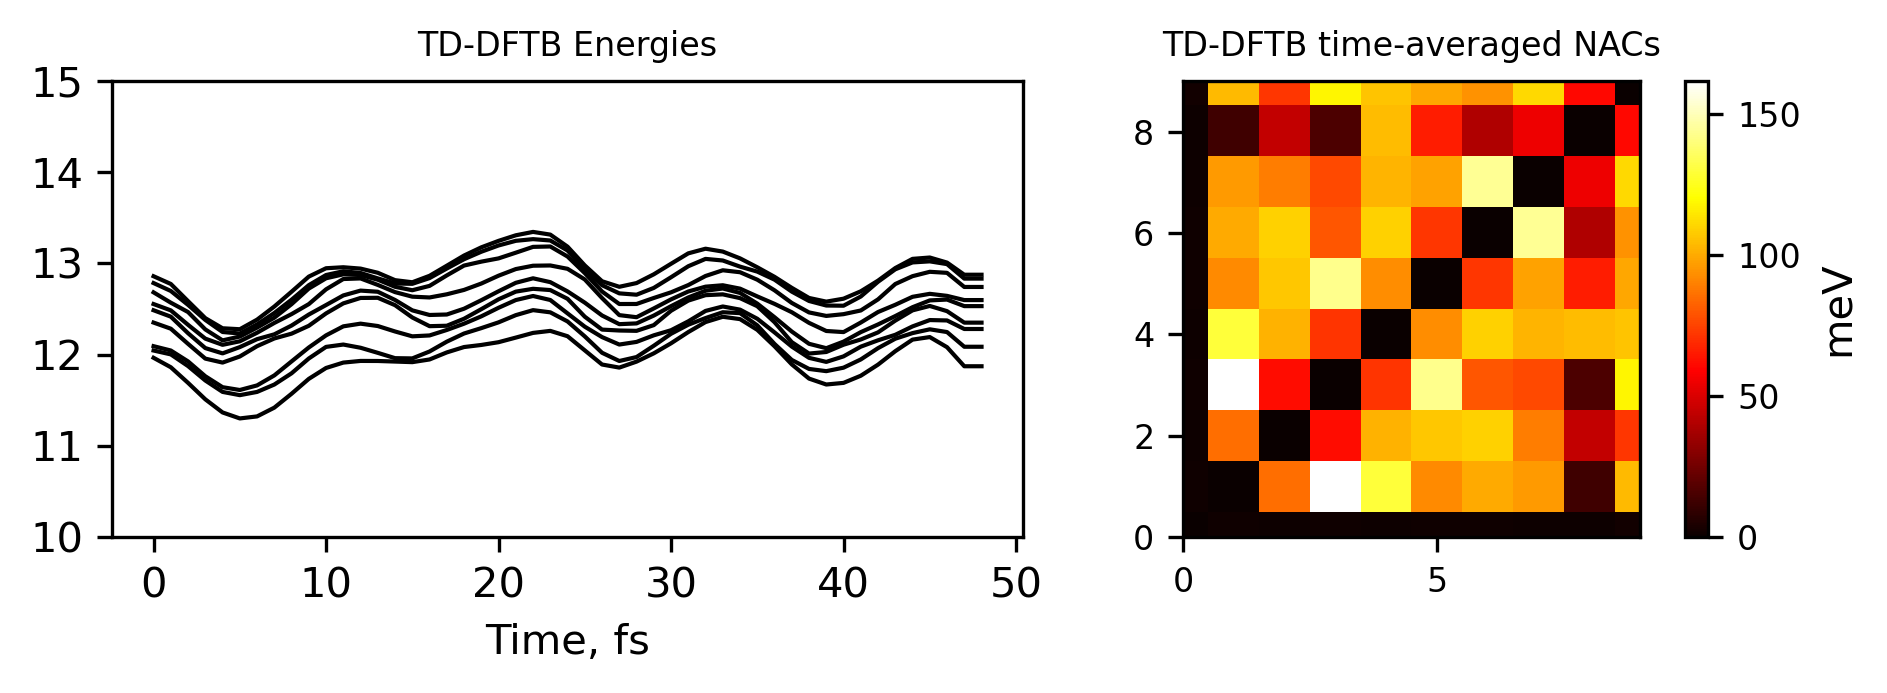

In [42]:
nstates = 10

# Figures - Time-Dependent Data
plt.figure(num=None, figsize=(6.42, 2.41), dpi=300, edgecolor='black', frameon=True)
plt.subplot(1,2,1)
plt.ylim(10,15)
plt.title('TD-DFTB Energies', fontsize=8)
plt.xlabel('Time, fs')
for state in range( nstates ):    
    plt.plot(md_time, CI_energy[state]/units.ev2Ha, label="", linewidth=1, color = "black")
plt.tight_layout()


plt.subplot(1,2,2)
plt.title('TD-DFTB time-averaged NACs', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(0,nstates-1)
plt.ylim(0,nstates-1)
#plt.xticks([0,1,2,3,4,5,6,7,8,9])
#plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.imshow(ci_tNACs, cmap='hot', interpolation='nearest')
cb = plt.colorbar(label="meV")
cb.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

## 7. User-friendly version of the above workflow
[Return to TOC](#toc)<a name="7"></a>

Now, we can do all the above calculations in a single line (not counting the parameters setup). This is done with the help of the `step3_many_body.run` function:
<a name="run-1"></a>

In [43]:
help(step3_many_body.run)

Help on function run in module libra_py.workflows.nbra.step3_many_body:

run(_params)
    This function utilizes the single-particle results, results of TD-DFT(B) calculations, and
    user's definition of excited state basis to sompute the the Hvib in the many-body basis
    
    Args:
       _params (dict): control parameters
    
    Returns:
       None



In [44]:
path = os.getcwd()
params = { "data_set_paths": [ F"{path}/dftb_data/res/"],
           "logfile_directory":F"{path}/dftb_data/all_logfiles",
           "read_S_data" : 1, "read_S_re":1,  "read_S_im":0,
           "S_data_re_prefix": "S_ks_",  "S_data_re_suffix": "_re",
           "S_data_im_prefix": "S_ks_",  "S_data_im_suffix": "_im",
           "read_St_data" : 1, "read_St_re":1,  "read_St_im":0,
           "St_data_re_prefix": "St_ks_",  "St_data_re_suffix": "_re",
           "St_data_im_prefix": "St_ks_",  "St_data_im_suffix": "_im",
           "read_hvib_data" : 1, "read_hvib_re":1,  "read_hvib_im":0,
           "hvib_data_re_prefix": "E_ks_",  "hvib_data_re_suffix": "_re",
           "hvib_data_im_prefix": "E_ks_",  "hvib_data_im_suffix": "_im",
           "isnap":150, "fsnap":199, 
           "data_dim":62, "active_space":range(0,int(62/2)), 
           "orbital_indices":list( range(10, 41) ), "homo_index":28,
           "es_software":"dftb+", "isUKS":0, "tolerance":0.01, "number_of_states":10,
           "orbital_normalization":False, "orbital_phase_correction":False,
           "state_normalization":True, "state_phase_correction":True,
           "do_state_reordering":2, "state_reordering_alpha":0,
           "sorting_type":"energy", "dt": 1.0*units.fs2au,
           "outdir":F"{path}/dftb_data/res_mb_sp2/" }

Hvib = step3_many_body.run(params)

number of steps , nsteps=  48
Output the CI data to the res directory...


And then we can use the same piece of code as above to process and plot the produced data.

In [45]:
ntraj  = len(Hvib)
nsteps = len(Hvib[0])
nCIs   = Hvib[0][0].num_of_cols

# Make a list for the SD energies and populate it
CI_energy = []
md_time = list( range(nsteps) )
for sd_index in range( nCIs ):
    CI_energy.append( [] )
    for step in range( nsteps ):        
        En = Hvib[0][step].get( sd_index, sd_index ).real 
        E0 = Hvib[0][step].get( 0, 0 ).real
        CI_energy[ sd_index ].append( En - E0 )        
        
CI_energy  = np.array( CI_energy  )
md_time    = np.array( md_time )

# Compute the time-averaged CI NACs and make a list of them
ci_res = data_stat.cmat_stat2(Hvib[0], 2)
ci_tNACs = []
for i in range(nCIs):
    ci_tNACs.append( [] )
    for j in range(nCIs):
        ci_tNACs[i].append( ci_res.get(i,j).imag * 1000.0 / units.ev2Ha )        
ci_tNACs = np.array(ci_tNACs)


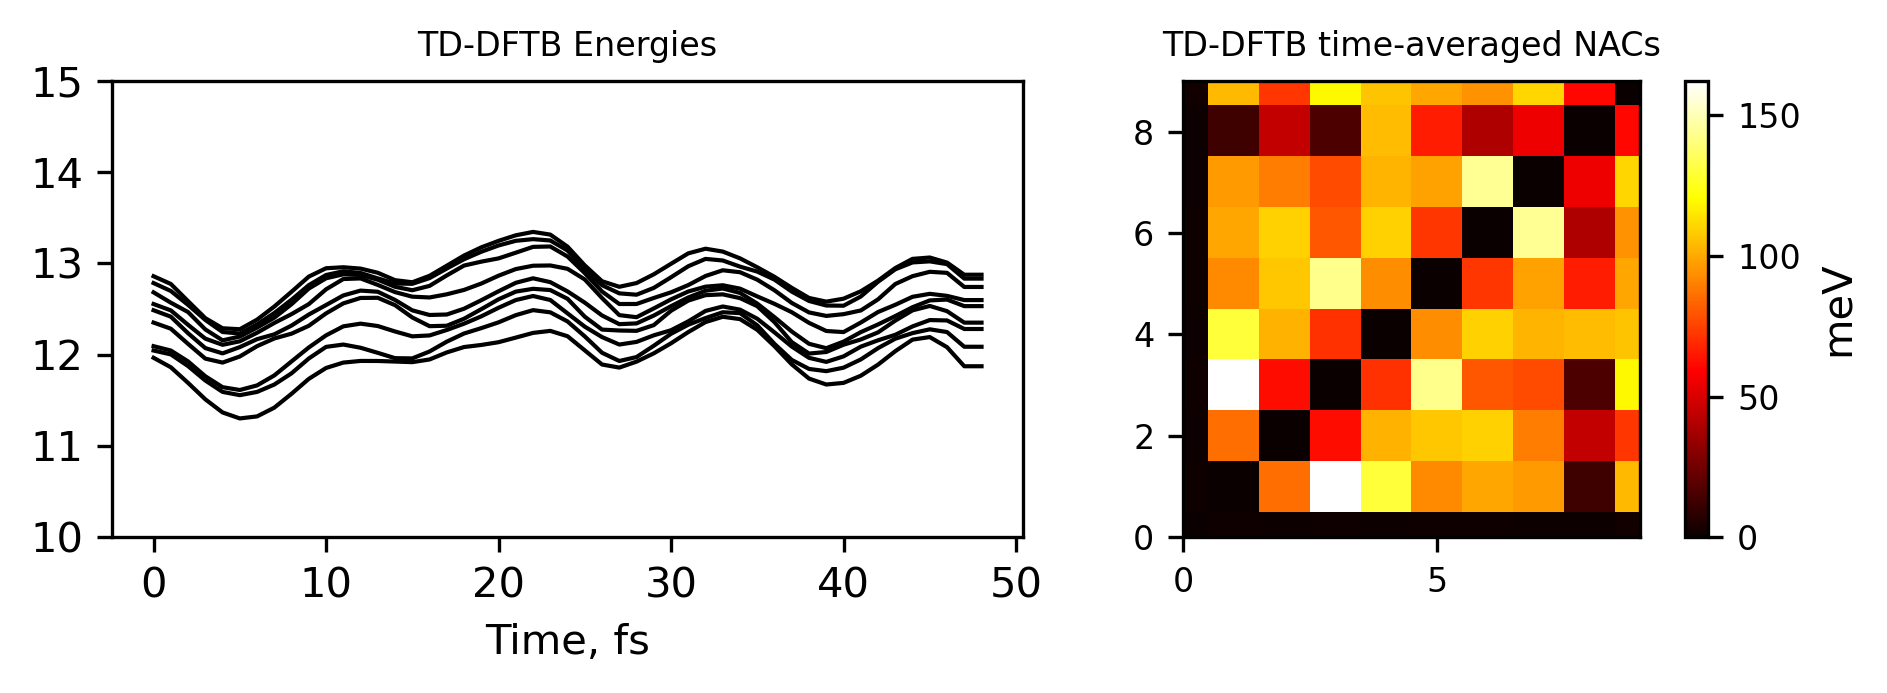

In [46]:
nstates = 10

# Figures - Time-Dependent Data
plt.figure(num=None, figsize=(6.42, 2.41), dpi=300, edgecolor='black', frameon=True)
plt.subplot(1,2,1)
plt.ylim(10,15)
plt.title('TD-DFTB Energies', fontsize=8)
plt.xlabel('Time, fs')
for state in range( nstates ):    
    plt.plot(md_time, CI_energy[state]/units.ev2Ha, label="", linewidth=1, color = "black")
plt.tight_layout()


plt.subplot(1,2,2)
plt.title('TD-DFTB time-averaged NACs', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(0,nstates-1)
plt.ylim(0,nstates-1)
#plt.xticks([0,1,2,3,4,5,6,7,8,9])
#plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.imshow(ci_tNACs, cmap='hot', interpolation='nearest')
cb = plt.colorbar(label="meV")
cb.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

## 8. Workflow for the CP2K data
[Return to TOC](#toc)<a name="8"></a>

Finally, we can repeat all of the above procedure with the data obtained with the CP2K package

In [47]:
#!tar -xf cp2k_data.tar.bz2

In [48]:
path = os.getcwd()
params = { "data_set_paths": [ F"{path}/cp2k_data/res/"],
           "logfile_directory":F"{path}/cp2k_data/all_logfiles",
           "read_S_data" : 1, "read_S_re":1,  "read_S_im":0,
           "S_data_re_prefix": "S_ks_",  "S_data_re_suffix": "_re",
           "S_data_im_prefix": "S_ks_",  "S_data_im_suffix": "_im",
           "read_St_data" : 1, "read_St_re":1,  "read_St_im":0,
           "St_data_re_prefix": "St_ks_",  "St_data_re_suffix": "_re",
           "St_data_im_prefix": "St_ks_",  "St_data_im_suffix": "_im",
           "read_hvib_data" : 1, "read_hvib_re":1,  "read_hvib_im":0,
           "hvib_data_re_prefix": "E_ks_",  "hvib_data_re_suffix": "_re",
           "hvib_data_im_prefix": "E_ks_",  "hvib_data_im_suffix": "_im",
           "isnap":150, "fsnap":199, 
           "data_dim":62, "active_space":range(0,int(62/2)), 
           "orbital_indices":list( range(10, 41) ), "homo_index":28,
           "es_software":"cp2k", "isUKS":0, "tolerance":0.0, "number_of_states":10,
           "orbital_normalization":False, "orbital_phase_correction":False,
           "state_normalization":True, "state_phase_correction":True,
           "do_state_reordering":2, "state_reordering_alpha":0,
           "sorting_type":"energy", "dt": 1.0*units.fs2au,
           "outdir":F"{path}/cp2k_data/res_mb_sp/" }

Hvib = step3_many_body.run(params)

number of steps , nsteps=  48
Output the CI data to the res directory...


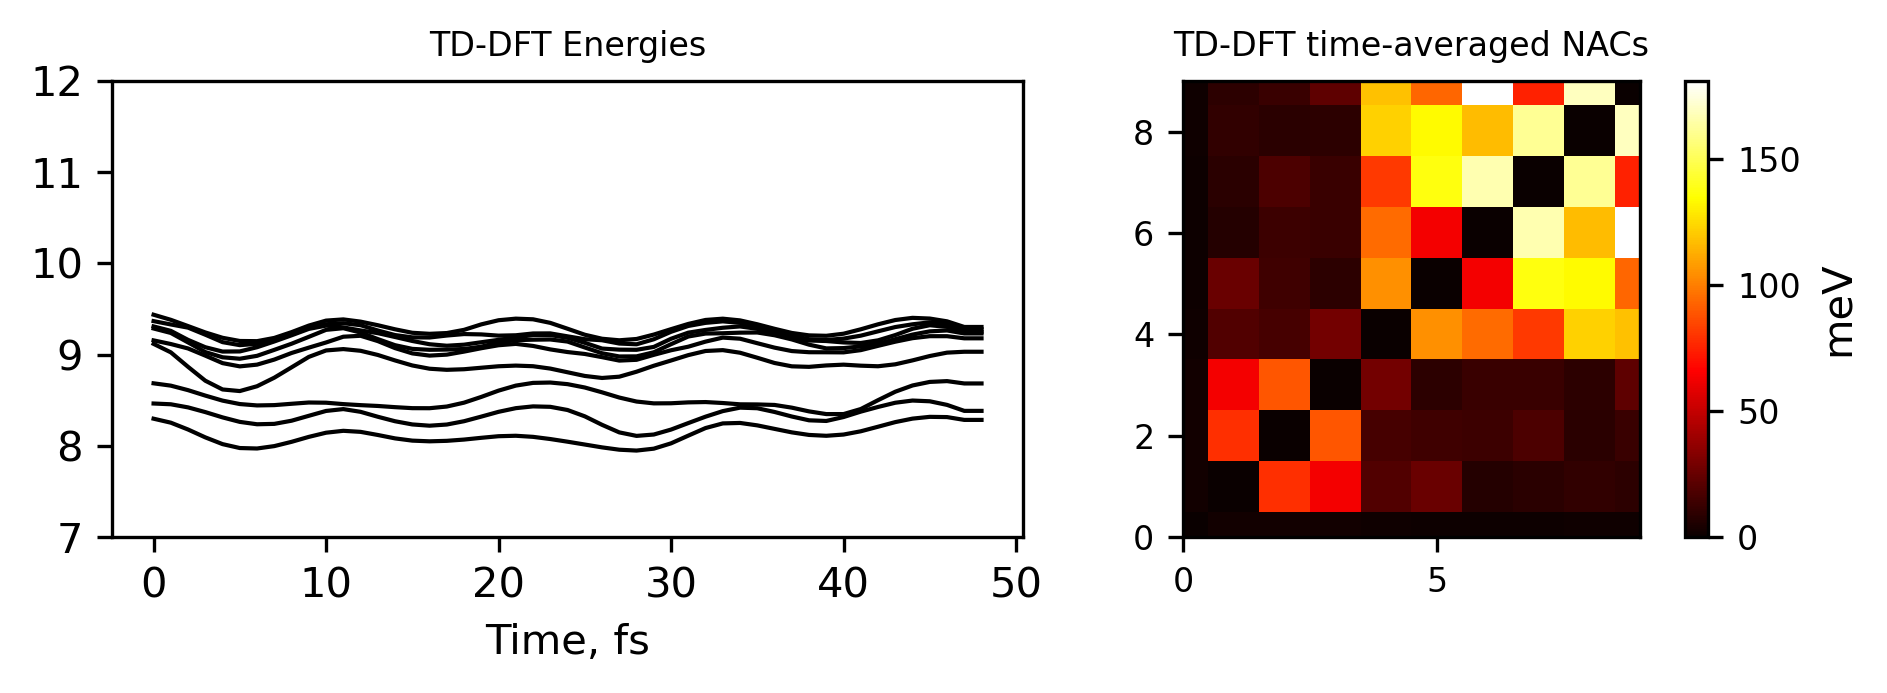

In [52]:
ntraj  = len(Hvib)
nsteps = len(Hvib[0])
nCIs   = Hvib[0][0].num_of_cols

# Make a list for the SD energies and populate it
CI_energy = []
md_time = list( range(nsteps) )
for sd_index in range( nCIs ):
    CI_energy.append( [] )
    for step in range( nsteps ):        
        En = Hvib[0][step].get( sd_index, sd_index ).real 
        E0 = Hvib[0][step].get( 0, 0 ).real
        CI_energy[ sd_index ].append( En - E0 )        
        
CI_energy  = np.array( CI_energy  )
md_time    = np.array( md_time )

# Compute the time-averaged CI NACs and make a list of them
ci_res = data_stat.cmat_stat2(Hvib[0], 2)
ci_tNACs = []
for i in range(nCIs):
    ci_tNACs.append( [] )
    for j in range(nCIs):
        ci_tNACs[i].append( ci_res.get(i,j).imag * 1000.0 / units.ev2Ha )        
ci_tNACs = np.array(ci_tNACs)


nstates = 10

# Figures - Time-Dependent Data
plt.figure(num=None, figsize=(6.42, 2.41), dpi=300, edgecolor='black', frameon=True)
plt.subplot(1,2,1)
plt.ylim(7,12)
plt.title('TD-DFT Energies', fontsize=8)
plt.xlabel('Time, fs')
for state in range( nstates ):    
    plt.plot(md_time, CI_energy[state]/units.ev2Ha, label="", linewidth=1, color = "black")
plt.tight_layout()


plt.subplot(1,2,2)
plt.title('TD-DFT time-averaged NACs', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(0,nstates-1)
plt.ylim(0,nstates-1)
#plt.xticks([0,1,2,3,4,5,6,7,8,9])
#plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.imshow(ci_tNACs, cmap='hot', interpolation='nearest')
cb = plt.colorbar(label="meV")
cb.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()